# Libraries

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns

from utils import *

%matplotlib inline

# Data import

## Epitope pairs

In [2]:
epitope_pairs_df = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/IEDB/Epitope_pairs_similar.csv")

## Epitope ID to PDB mapping

In [3]:
epitope_pdb_human = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Epitope_PDB_ID.csv")

## ANARCI annotations

ANARCI antibody numbering performed using IMGT scheme (see https://pipebio.com/blog/antibody-numbering)

```
ANARCI -i ~/clustering-comparison/data/FASTA/Antibody_pairs_seq_[heavy|light]_chain_human.fasta -o ~/clustering-comparison/data/ANARCI/Antibody_pairs_[heavy|light]_chain_ANARCI_human.txt -s imgt --use_species human
```

In [4]:
ig_seq_dict_heavy_human = read_anarci_results_file(os.path.dirname(os.getcwd()) + 
    "/data/ANARCI/Antibody_pairs_heavy_chain_ANARCI_human.txt", "H")
ig_seq_dict_light_human = read_anarci_results_file(os.path.dirname(os.getcwd()) + 
    "/data/ANARCI/Antibody_pairs_light_chain_ANARCI_human.txt", "L")

# Identify CDRH3 regions

In [5]:
ab_seq_heavy_df_human = create_sequence_dataframe(ig_seq_dict_heavy_human, "H")
ab_seq_light_df_human = create_sequence_dataframe(ig_seq_dict_light_human, "L")

In [6]:
# merge all information into one dataframe
epitope_pdb_ab_seq_human = merge_sequence_information(epitope_pdb_human, ab_seq_heavy_df_human, ab_seq_light_df_human)
epitope_pdb_ab_seq_human = epitope_pdb_ab_seq_human[~epitope_pdb_ab_seq_human["Epitope_ID"].isin([2218019, 2218035])] 
epitope_pdb_ab_seq_human[:5]

Number of ANARCI numbered antibody sequences: 112
Number of filtered ANARCI numbered antibody sequences: 90


,Epitope_ID,PDB,Heavy_chain,CDRH3,Light_chain,CDRL3
0,2218036,2EKS,QVQLQESGPGLMKPSETLSLTCSVSGDSIRSDYWSWIRQPPGKGLE...,ARWDGDY,EIVMTQSPATLSVSPGERATLSCRASQSIGNNLHWYQQKPGQAPRL...,QQSNSWPYT
3,164074,1GC1,QVQLLESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQGLE...,AGVYEGEADEGEYDNNGFLKH,ELELTQSPATLSVSPGERATLSCRASESVSSDLAWYQQKPGQAPRL...,QQYNNWPPRYT
4,164069,1G9N,QVQLLESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQGLE...,AGVYEGEADEGEYRNNGFLKH,ELELTQSPATLSVSPGERATLSCRASESVSSDLAWYQQKPGQAPRL...,QQYNNWPPRYT
5,164067,2I5Y,EVQLVESGAEVKKPGSSVKVSCKASGDTFIRYSFTWVRQAPGQGLE...,AGVYEGEADEGEYDNNGFLKH,DIVMTQSPATLSVSPGERATLSCRASESVSSDLAWYQQKPGQAPRL...,QQYNNWPPRYT
9,2135094,3B2V,QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGDYYWSWIRQPPGKG...,ARVSIFGVGTFDY,EIVMTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,HQYGSTPLT


# Calculate sequence distances
For documentation see: https://maxbachmann.github.io/Levenshtein/levenshtein.html

In [7]:
print("Human antibodies")
antibody_pairs_human, epitope_set_human = create_antibody_pair_dataframe(epitope_pairs_df, epitope_pdb_ab_seq_human)

Human antibodies
Number of antibody pairs before filtering: 239
Number of unique antibodies before filtering: 59
Number of antibody pairs: 213
Number of unique antibodies: 54


### Add epitope pair information

In [8]:
antibody_pairs_human = epitope_pairs_df[["Epitope_ID_A", "Epitope_ID_B", "Antigen", "Species", 
    "Jaccard_score"]].merge(antibody_pairs_human, on=["Epitope_ID_A", "Epitope_ID_B"], how="inner")

In [9]:
# filter epitope dataframe for included epitope IDs, drop duplicates
epitope_pdb_ab_seq_human_filtered = epitope_pdb_ab_seq_human[epitope_pdb_ab_seq_human \
    ["Epitope_ID"].isin(epitope_set_human)].drop_duplicates(subset=["Epitope_ID"])

# Data visualization

In [10]:
df_plotting = antibody_pairs_human.sort_values("Species", ascending=False)
df_plotting["Species"] = np.where(df_plotting["Species"] == "Severe acute respiratory syndrome coronavirus 2", 
    "SARS-CoV-2", df_plotting["Species"])
df_plotting["Species"] = np.where(df_plotting["Species"] == "Human immunodeficiency virus 1", "HIV", 
    df_plotting["Species"])
df_plotting["Species"] = np.where(df_plotting["Species"] == "Saccharomyces cerevisiae", "S. cerevisiae", 
    df_plotting["Species"])
df_plotting["Species"] = np.where(df_plotting["Species"] == "Plasmodium falciparum", "P. falciparum", 
    df_plotting["Species"])

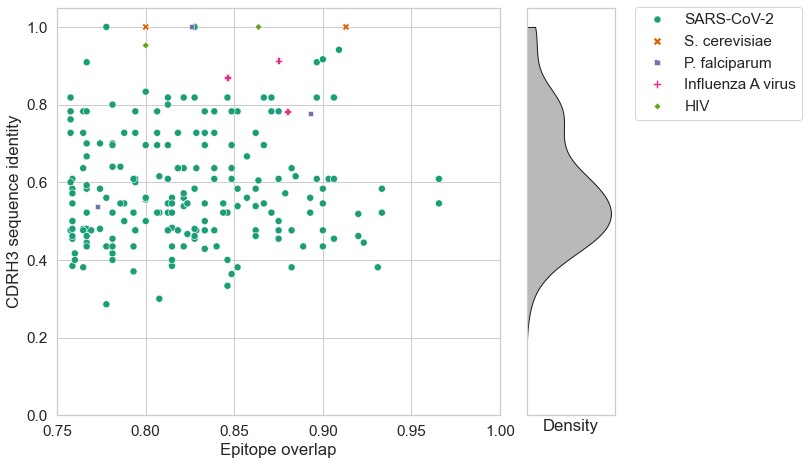

In [11]:
sns.set(style=("whitegrid"), font_scale=1.4)
fig, ax = plt.subplots(1, 2, figsize=(10,7.5), width_ratios=[5, 1], sharey=True)
plt.subplots_adjust(wspace=0.1)

sns.scatterplot(data=df_plotting, x="Jaccard_score", y="Distance_normalized", hue="Species", style="Species", 
    s=50, palette="Dark2", ax=ax[0])
ax[0].set(title=None, xlabel="Epitope overlap", ylabel="CDRH3 sequence identity", xlim=(0.75,1), ylim=(0,1.05))

sns.kdeplot(data=antibody_pairs_human, y="Distance_normalized", fill=True, clip=[0,1], alpha=.3, color="k", ax=ax[1])
ax[1].grid(False)
ax[1].set(ylabel=None);
ax[1].set_xticks([])

ax[0].legend(bbox_to_anchor=(1.7, 1.02))

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/CDRH3_seq_identity_epitope_overlap_antibody_pairs.png", dpi=300, 
    transparent=True, bbox_inches="tight")

In [12]:
species_list = []
for i in epitope_set_human:
    if i in df_plotting["Epitope_ID_A"].values:
        species_list.append(df_plotting[df_plotting["Epitope_ID_A"] == i]["Species"].values[0])
    elif i in df_plotting["Epitope_ID_B"].values:
        species_list.append(df_plotting[df_plotting["Epitope_ID_B"] == i]["Species"].values[0])
        
species_count = pd.Series(species_list).value_counts().sort_index(ascending=False, key=lambda x: x.str.lower())

In [13]:
species_clusters = {}

# collect separate clusters for each antigen species
for species in df_plotting["Species"].unique():
    df_species_specific = df_plotting[df_plotting["Species"] == species]
    G = nx.from_pandas_edgelist(df_species_specific, "Epitope_ID_A", "Epitope_ID_B")
    clusters = list(nx.connected_components(G))
    species_clusters[species] = clusters
    
species_cluster_sizes = {species: [len(element) for element in values] for species, values in species_clusters.items()}

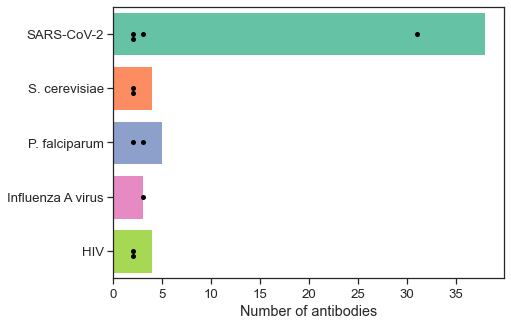

In [14]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.barh(y=species_count.index, width=species_count.values, color=sns.color_palette("Set2"));
for i, (species, set_lengths) in enumerate(species_cluster_sizes.items()):
    sns.swarmplot(y=[species] * len(set_lengths), x=set_lengths, color="black")
ax.set(xlabel="Number of antibodies")
    
plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Species_fractions_antibody_pairs.png", dpi=300, transparent=True,
    bbox_inches="tight")

In [15]:
# create a new dictionary with increasing integers as keys
species_clusters_numbered = {}
count = 0
for key, value in species_clusters.items():
    for item in value:
        species_clusters_numbered[count] = item
        count += 1

In [16]:
# add species cluster to dataframe
antibody_pairs_human["Cluster"] = None

for key, value in species_clusters_numbered.items():
    for item in value:
        antibody_pairs_human.loc[antibody_pairs_human["Epitope_ID_A"].isin([item]), "Cluster"] = key
        antibody_pairs_human.loc[antibody_pairs_human["Epitope_ID_B"].isin([item]), "Cluster"] = key

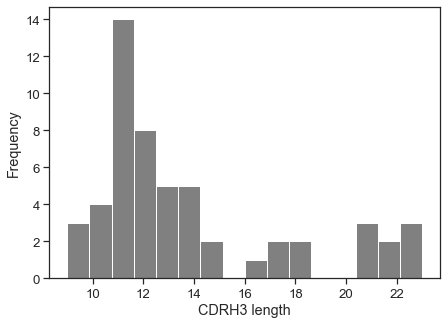

In [17]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# each CDRH3 length represented by own bin
epitope_pdb_ab_seq_human_filtered["CDRH3"].apply(len).plot.hist(bins=16, color="grey", ax=ax)
ax.set(title=None, xlabel="CDRH3 length")

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/CDRH3_length_antibody_pairs.png", dpi=300, transparent=True,
    bbox_inches="tight")

# Save data

In [18]:
epitope_pdb_ab_seq_human_filtered.to_csv(os.path.dirname(os.getcwd()) + 
    "/data/antibody_pairs/Epitope_PDB_ID_ABseq_CDRH3.csv", index=False)

In [19]:
antibody_pairs_human.to_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs.csv", index=False)

In [20]:
epitope_pdb_human_antibody_pairs = epitope_pdb_human[epitope_pdb_human["Epitope_ID"].isin(epitope_set_human)]
antibody_pairs_PDB = epitope_pdb_human_antibody_pairs.drop_duplicates(["Epitope_ID"])["PDB"]
print("Number of associated PDB IDs:", len(antibody_pairs_PDB))

Number of associated PDB IDs: 54
